# Statistical Downgradation of Rainfall

### Here we shall use the weather variables to predict rainfall at nearby coordinates

## Libraries

The libraries we will put into use here are:

1. Keras: It is an API to create deep learning models. We will be using this primarily

2. Pandas: We will be using dataframe to store the weather data

3. Numpy: Well, didn't use that, but might need to later...

4. Matplotlib: For plots and Graphs

5. Scikit Learn: For model evaluation metrics and feature selection

6. Seaborn: Another plotting library we didn't use yet

In [46]:
'''
INCLUDING NECESSARY LIBRARIES
'''
#Os for pathnames
import os
#Required for data structu
import pandas as pd
import numpy as np
#Keras Funcions
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers.experimental.preprocessing import Normalization
from keras import initializers
from keras import metrics 
from keras import backend as K
#Plotting Libraries
import matplotlib.pyplot as mpl
import seaborn as sns
#SciKit Learn Important Utility Functions
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#Scikit learn feature selection techniques
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
#Scikit learn 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Get the current working directory
cwd = os.getcwd()
print(cwd)

C:\Users\kayde\OneDrive\Desktop\mannada\RainfallData


## Data Acquisition

For X data, we have 31 variables spread across different files, Hence we use a list to define all the variable names, then we take each variable and get the required file to fill its column in the dataframe.

For Y well, its just one file we acquired it anyway. :)

In [2]:
#the variables as recorded by the station
variables = [
        'dswr',
        'lftx',
        'mslp',
        'p__f',
        'p__u',
        'p__v',
        'p__z',
        'p_th',
        'p_zh',
        'p5_f',
        'p5_u',
        'p5_v',
        'p5_z',
        'p5th',
        'p5zh',
        'p8_f',
        'p8_u',
        'p8_v',
        'p8_z',
        'p8th',
        'p8zh',
        'p500',
        'p850',
        'pottmp',
        'pr_wtr',
        'prec',
        'r500',
        'r850',
        'rhum',
        'shum',
        'temp',
]

#The three regions
regions = [
        '82.5', #A
        '85.0', #B
        '87.5', #C
]

'''
TAKING IN ALL THE X VARIABLES
'''

#define an empty dictionary
boxes = {}

#iterating over regions
for region in regions:
    
    df_li = pd.DataFrame() # empty dataframe
    
    #iterating over variables
    for var in variables:
        
        path = os.path.join(cwd,"DATA\\BOX_20N_%sE\\ncep_%s.dat"%(region,var)) # path for X data
        
        with open(path) as file: #open the respected variable file for the region
            
            temp = file.read().splitlines()
            temp = [float(i) for i in temp]
            
        df_li[region + '_' + var] = temp #and for every variable, store that data under header: <coordinate_variable>
        
    boxes[region]=df_li #and assign that dataframe for every region
    
'''
TAKING IN ALL THE Y VALUES
'''

rain = []

for i in range(5): # iterate from 0 to 4 i.e. 5 times
    
    path = os.path.join(cwd,"DATA\\rain%d.dat"%(i+1)) # join cwd to path of rain data
    
    with open(path) as file:
        
        lines = file.read().splitlines()
        lines = [float(i) for i in lines]
        rain.append( lines )  #store in rain list

#time for some data refining and model training

#Trimming BOXES, this is to match with the rain data, day-by-day
for region in regions:
    boxes[region] = boxes[region].iloc[4749:,] # removing 4749 rows from front
    boxes[region] = boxes[region].iloc[:10957,] # keeping only 10957 of the rest

#sample take BOX A and PLACE 1
dfBox = boxes['82.5']
rain1 = rain[0]

## Class Definition
Here the main predictioknfjihsdfvhdslkjbgf

In [60]:
class predictionModel:
    '''
    This is a class defining the Prediction Neural Network, Its input filtering,
    '''
    def __init__(self,X,Y,classStr,layer1_node=31,layer2_node=31):
        self.__cStr = classStr
        self.__layer1_node = layer1_node
        self.__layer2_node = layer2_node
        self.__xdata = X
        self.__ydata = Y
        self.__inpdim = len(X[0])
        self.__class = classStr
        self.__trained = False
        if classStr == 'regression':
            self.__model = self.__neuralNetworkRegressor()
        elif classStr == 'classification':
            self.__model = self.__neuralNetworkClassifier()
        else:
            print('\nError: model %s not found'%(classStr))
    def R2Coefficient(self,y_true, y_pred):
        SS_res =  K.sum( K.square( y_true - y_pred ) ) 
        SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
        return ( 1 - SS_res/( SS_tot + K.epsilon() ) )
    
    def __neuralNetworkRegressor(self):
        model = Sequential(
            [
                BatchNormalization(
                    input_shape=[self.__inpdim],
                    axis=-1,
                    momentum=0.99,
                    epsilon=0.001,
                    center=True,
                    beta_initializer="zeros",
                    moving_mean_initializer="zeros",
                    moving_variance_initializer="ones",
                    beta_regularizer=None,
                    beta_constraint=None,
                ),
                Dense(
                    self.__layer1_node,
                    input_dim=self.__inpdim,
                    activation = 'relu',
                    kernel_initializer=initializers.HeNormal(seed=None),
                    bias_initializer='zeros',
                ),
                Dense(
                    self.__layer2_node,
                    activation = 'relu',
                    kernel_initializer=initializers.HeNormal(seed=None),
                    bias_initializer='zeros',
                ),
                Dense(
                    int(self.__layer2_node/2),
                    activation = 'relu',
                    kernel_initializer=initializers.HeNormal(seed=None),
                    bias_initializer='zeros',
                ),
                Dense(
                    1,
                    kernel_initializer='normal',
                    bias_initializer='zeros',
                ),
            ]
        )
        model.compile(loss= "mse" , optimizer="adam", metrics=[metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)])
        return model
    
    def __neuralNetworkClassifier(self):
        
        model = Sequential(
            [
                Dense(
                    self.__layer1_node,
                    input_dim = self.__inpdim,
                    activation = 'relu',
                    kernel_initializer=initializers.HeNormal(seed=None), #He Normal goes good with relu
                    bias_initializer='zeros',
                ),
                Dense(
                    self.__layer2_node,
                    activation = 'relu',
                    kernel_initializer=initializers.HeNormal(seed=None), #He Normal goes good with relu
                    bias_initializer='zeros',
                ),
                Dense(
                    1,
                    activation='sigmoid', # heard its the best activation for classfication output
                    kernel_initializer='normal',
                    bias_initializer='zeros',
                ),
            ]
        )
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        return model
    
    def trainNetwork(self, epoch = 10, batch = 5):
        xtrain, xtest, ytrain, ytest = train_test_split(self.__xdata,self.__ydata,test_size=0.2)#splitting test-train
        print("Initiating Training Sequence\n")
        history = self.__model.fit(
            xtrain,
            ytrain,
            epochs = epoch,
            batch_size = batch,
        )
        print("\n\nInitiating Testing Sequence\n")
        metrics = self.__model.evaluate(
            xtest,
            ytest,
            batch_size = 5,
        )
        self.__trained = True
        
    def evaluateNetwork(self):
        '''
        This Function isn't really working now,
        Will come back later
        '''
        if self.__trained == False:
            print("ERROR: Model Not Trained")
            return
        print("\nInitiating Evaluation Sequence\n")
        evaluators=[
            ('standardize',StandardScaler()),
            ('mlp',KerasRegressor(
                build_fn =  self.__neuralNetwork(self.__K1,self.__K2),
                epochs = 10,
                batch_size = 5,
                verbose = 0,
            )),
        ]
        pipeline = Pipeline(evaluators)
        results = cross_val_score(
            pipeline,
            self.__xdata,
            self.__ydata,
            cv = KFold(n_splits=10)
        )
        print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
        
    def predictData(self,X):
        if self.__trained == False:
            inp = input("ERROR: Model Not Trained, Want to train now? (Y/N)");
            if inp == 'N':
                return
            elif inp == 'Y':
                self.trainNetwork()
        Y = []
        Y = self.__model.predict(X)
        return(Y)
    def plotData(self,X,yreal,ypred=None,pltstr='r.'):
        if ypred.any() == None:
            ypred = self.predictData(X)
        if self.__trained == False:
            inp = input("ERROR: Model Not Trained, Want to train now? (Y/N)");
            if inp == 'N':
                return
            elif inp == 'Y':
                self.trainNetwork()
        '''
        X and Y are evaluation datasets
        pltStr is the plot type as put in matplotlib
        '''
        
        realmax = max(yreal)
        predmax = max(ypred)
        lgt = min(predmax,realmax)+10
        x = np.linspace(0, lgt, 100)
        mpl.rcParams["figure.figsize"] = [10, 10]
        mpl.plot(yreal,ypred,pltstr)
        mpl.plot(x,x,label="convergence")
        mpl.xlabel("Actual Rain Level")
        mpl.ylabel("Predicted Rain Level")
        leg = mpl.legend(loc='upper center')
        mpl.show()
        return
        

## Filter Methods

Well 31 are a lot of variables, we need to get rid of some
that brings us to the concept of Feature Selection Which are

1. **Filter Methods:** Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. These methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods.

2. **Wrapper Methods:** Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

3. **Embedded Methods:** These methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

So Lets get Started!!

# Filter Methods: Information Gain

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable. Note that it turned out to be a **classification exclusive**

For this we use `sklearn.feature_selection.mutual_info_classif`

In [58]:
'''
xdf_1 = dfBox.copy()
ydata_1 = rain1.copy()
for i in range(len(ydata_1)):
    if ydata_1[i] > 2.5:
        ydata_1[i] = 1
    else:
        ydata_1[i] = 0
xdata_1 = xdf_1.values.tolist()

pred1 = predictionModel(xdata_1,ydata_1,'classification',31,10)
pred1.trainNetwork()
ypred_1 = pred1.predictData(xdata_1)

mpl.hist(abs(ypred_1 - ydata_1),bins=1000)
#pred1.plotData(xdata_1,ydata_1,ypred_1,'r.')
'''

"\nxdf_1 = dfBox.copy()\nydata_1 = rain1.copy()\nfor i in range(len(ydata_1)):\n    if ydata_1[i] > 2.5:\n        ydata_1[i] = 1\n    else:\n        ydata_1[i] = 0\nxdata_1 = xdf_1.values.tolist()\n\npred1 = predictionModel(xdata_1,ydata_1,'classification',31,10)\npred1.trainNetwork()\nypred_1 = pred1.predictData(xdata_1)\n\nmpl.hist(abs(ypred_1 - ydata_1),bins=1000)\n#pred1.plotData(xdata_1,ydata_1,ypred_1,'r.')\n"

Initiating Training Sequence

Epoch 1/20
956/956 [==============================] - 1s 1ms/step - loss: 734.6877 - root_mean_squared_error: 27.1051
Epoch 2/20
956/956 [==============================] - 1s 1ms/step - loss: 703.5877 - root_mean_squared_error: 26.5252
Epoch 3/20
956/956 [==============================] - 1s 1ms/step - loss: 673.8850 - root_mean_squared_error: 25.9593
Epoch 4/20
956/956 [==============================] - 1s 1ms/step - loss: 645.8685 - root_mean_squared_error: 25.4139
Epoch 5/20
956/956 [==============================] - 1s 1ms/step - loss: 619.4167 - root_mean_squared_error: 24.8881
Epoch 6/20
956/956 [==============================] - 1s 1ms/step - loss: 594.3870 - root_mean_squared_error: 24.3801
Epoch 7/20
956/956 [==============================] - 1s 1ms/step - loss: 570.8066 - root_mean_squared_error: 23.8916
Epoch 8/20
956/956 [==============================] - 1s 1ms/step - loss: 548.8080 - root_mean_squared_error: 23.4267
Epoch 9/20
956/956 [======

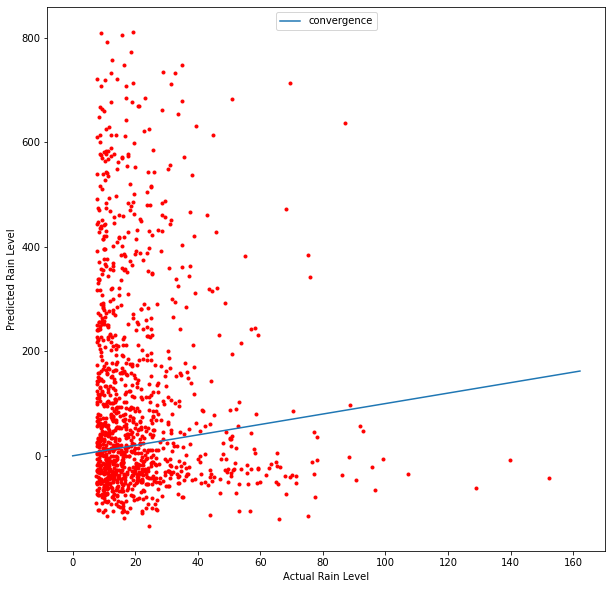

In [61]:
#35.5
xdf_2 = dfBox.copy()
xdf_2['rain'] = rain1
xdf_2 = xdf_2[ xdf_2['rain'] > 7.6 ]
xdf_2.describe()

ydata_2 = xdf_2['rain'].values.tolist()
xdata_2 = xdf_2.drop(['rain'], axis=1).values.tolist()
pred2 = predictionModel(xdata_2,ydata_2,'regression',31,60)
pred2.trainNetwork(20,1)
yres_2 = pred2.predictData(xdata_2)
pred2.plotData(xdata_2,ydata_2,yres_2,'r.')

In [ ]:
'''

#correaltion coefficient

#random forest importance

Percentile

top 25% underprediction : Class 1

top 25% - 90% regressive : Class 2

bottom 90% to 100% overprediction: Class 3


plot y  to error

'''